In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch.utils.data import DataLoader

from data.scannet.utils_scannet import ScanNetDataset
from matching.gmflow_dense.gmflow_dense import GMflowDensePose
from matching.gmflow_essential.gmflow_with_essential import GMFlowEssential
from utils.model import load_checkpoint
from utils.metrics import mAA, rotation_angle_distance_batch, vector_angle_distance_batch

from training.train_dense import test
from training.train_essential import test_ess

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import numpy as np
from numpy.linalg import norm

import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 0. Data

In [8]:
test_data = ScanNetDataset(
    root_dir='/home/project/ScanNet/scannet_test_1500/',
    npz_path='/home/project/ScanNet/test.npz',
    intrinsics_path='/home/project/ScanNet/intrinsics_test.npz',
    mode='test'
)

test_loader = DataLoader(test_data, batch_size=3, shuffle=False, drop_last=False, pin_memory=True, num_workers=1)


## 1. Metrics

In [6]:
metrics = {}
with open('/home/project/code/results/scannet/metrics', 'rb') as f:
    metrics = pickle.load(f)

### 1.1 GMFlow + dense

In [8]:
checkpoint = load_checkpoint('/home/project/code/src/weights/2_gmflow_dense_wo_conf_part2_3.pth', device)
model = GMflowDensePose()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [9]:
results = test(model, test_loader, device)

  0%|                                                                                           | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [03:35<00:00,  2.32it/s]


In [11]:
name = "GMFlow + dense"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l1': norm(results['t_gt'] - results['t'], ord=1, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=1, axis=1)
}

In [12]:
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=5, N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=10, N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=20, N=10000):.4f}')

mAA 5 rotation       0.0587
mAA 10 rotation      0.1770
mAA 20 rotation      0.3631


### 1.2 GMFlow + conf + dense

In [13]:
checkpoint = load_checkpoint('/home/project/code/src/weights/3_gmflow_dense_with_conf_part2_2.pth', device)
model = GMflowDensePose(conf_module=True)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [14]:
results = test(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [03:21<00:00,  2.48it/s]


In [16]:
name = "GMFlow + conf.module + dense"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l1': norm(results['t_gt'] - results['t'], ord=1, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=1, axis=1)
}

In [17]:
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=5, N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=10, N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=20, N=10000):.4f}')

mAA 5 rotation       0.0459
mAA 10 rotation      0.1561
mAA 20 rotation      0.3382


### 1.3 GMFlow + dense + l2

In [27]:
checkpoint = load_checkpoint('/home/project/code/src/weights/6_gmflow_dense_wo_conf_l2_3channels_4.pth', device)
model = GMflowDensePose(init_loss_weights=[0.0, 3.0, 0.0])
model.load_state_dict(checkpoint['model'])
model.to(device);

In [28]:
results = test(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [03:20<00:00,  2.49it/s]


In [29]:
name = "GMFlow + dense + l2"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l1': norm(results['t_gt'] - results['t'], ord=1, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=1, axis=1)
}

In [30]:
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=5, N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=10, N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["R_angle_distances"], thresh=20, N=10000):.4f}')

mAA 5 rotation       0.0666
mAA 10 rotation      0.1833
mAA 20 rotation      0.3613


### 1.4 GMFLow + conf + F.est

In [11]:
checkpoint = load_checkpoint('/home/project/code/src/weights/4_gmflow_with_conf_and_essential_4.pth', device)
model = GMFlowEssential()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [23]:
results = test_ess(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:27<00:00,  2.41it/s]


In [36]:
angle_distance = np.minimum(rotation_angle_distance_batch(results['R_gt'], results['R1']), rotation_angle_distance_batch(results['R_gt'], results['R2']))
t_angle_distance = np.minimum(vector_angle_distance_batch(results['t_gt'], results['t']), vector_angle_distance_batch(results['t_gt'], -results['t']))

In [40]:
print(f'{"mAA 5 rotation":<20} {mAA(angle_distance, t_angle_distance, thresh=5, N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(angle_distance, t_angle_distance, thresh=10, N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(angle_distance, t_angle_distance, thresh=20, N=10000):.4f}')

mAA 5 rotation       0.0000
mAA 10 rotation      0.0000
mAA 20 rotation      0.0000


#### Saving metrics

In [120]:
with open('metrics', 'wb') as f:
    pickle.dump(metrics, f)

# Plots

In [7]:
plt.style.use('default')

rc('text', usetex=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

rc('font', size=MEDIUM_SIZE)          # controls default text sizes
rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [8]:
def calculate_metric_on_subset(metric_values, values_dependent_on, agg_func, thresholds, sign):
    thresholds_ = thresholds[:, None]
    if sign == '>':
        inliers_bool = values_dependent_on > thresholds_
    else:
        inliers_bool = values_dependent_on <= thresholds_
    scores = np.array([agg_func(metric_values[subset]) for subset in inliers_bool])
    return scores

In [12]:
metrics['GMFlow + dense'].keys()

dict_keys(['R_angle_distances', 't_angle_distances', 't_distance_l1', 'R_gt_distance', 't_gt_distacne', 'R_gt_distances', 't_gt_distances'])

KeyError: 't_distances_l2'

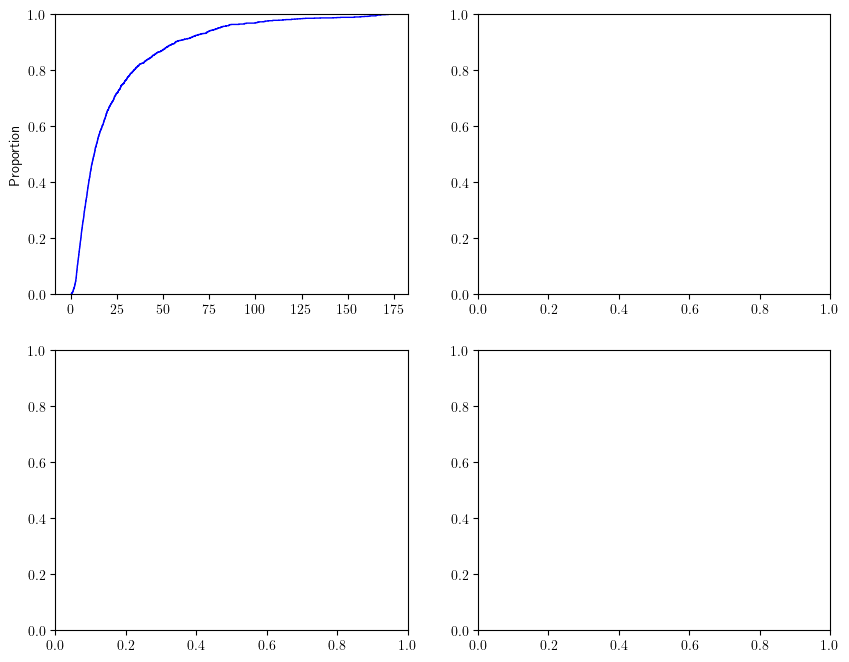

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

colors = ['b', 'darkorange' ,'g', '#8B008B',
          '#A52A2A','#FFC0CB','#808080','#556B2F','#00FFFF',
         '#FF00FF','#32CD32','#008080','#E6E6FA',
         '#D2B48C','#FA8072','#FFD700', '#000080']

exp_colors = {exp: col for  exp, col in zip(metrics.keys(), colors)}

for exp, m in metrics.items():
    sns.ecdfplot(x=m['R_angle_distances'], complementary=False, ax=ax[0,0], c=exp_colors[exp], linewidth=1)    

    sns.ecdfplot(x=m['t_distances_l2'], complementary=False, ax=ax[0,1], c=exp_colors[exp], linewidth=1, log_scale=False)

    R_on_gt = calculate_metric_on_subset(
        m['R_angle_distances'], m['R_gt_distances'], np.mean, np.linspace(0, 180, 180), '<')
    R_on_gt[np.isnan(R_on_gt)] = 0
    ax[1, 0].plot(np.linspace(0, 180, 180), R_on_gt, label=exp, c=exp_colors[exp], linewidth=1)
    
    t_on_gt = calculate_metric_on_subset(
        m['t_distances_l2'], m['t_gt_distances'], np.mean, np.linspace(0, 6.66, 100), '<')
    t_on_gt[np.isnan(t_on_gt)] = 0
    ax[1, 1].plot(np.linspace(0, 6.66, 100), t_on_gt, c=exp_colors[exp], linewidth=1)

    
    
ax[0, 0].set_xlim([0., 50.])
ax[0, 0].set_xticks(np.linspace(0, 50, 11, dtype='int'))
ax[0, 0].set_yticks(np.linspace(0, 1, 11))
ax[0, 0].set_ylabel('Fraction of observations')
ax[0, 0].set_xlabel('Angle error, degrees')
ax[0, 0].set_title('CDF of angle error')
ax[0, 0].grid(alpha=0.5)


ax[0, 1].set_xlim([0., 3.])
ax[0, 1].set_yticks(np.linspace(0, 1, 11))
ax[0, 1].set_ylabel('Fraction of observations')
ax[0, 1].set_xlabel('$\|t_{gt} - t\|_2$, meters')
ax[0, 1].set_title('CDF of translation error')
ax[0, 1].grid(alpha=0.5)


n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['R_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['R_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_10 = ax[1, 0].twinx() # create secondary axis with shared x-axis  
ax_10.step(bin_centers,cdf_values,'r', label='Fraction of observations')
ax_10.set_ylabel('Fraction of observations')
ax_10.set_yticks(np.linspace(0, 1, 11))
ax_10.grid(alpha=0.5)
ax[1, 0].set_xlabel('Ground-truth rotation distance $<$ than, degrees')
ax[1, 0].set_ylabel('Mean error, degrees')
ax[1, 0].set_title('Dependence of mean angle error on \n ground-truth rotation distance')
ax[1, 0].grid(axis='x', alpha=0.5)

n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['t_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['t_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_11 = ax[1, 1].twinx() # create secondary axis with shared x-axis  
ax_11.step(bin_centers, cdf_values, 'r', label='Fraction of observations')
ax_11.set_ylabel('Fraction of observations')
ax_11.set_yticks(np.linspace(0, 1, 11))
ax_11.grid(alpha=0.5)
ax[1, 1].set_xticks(np.linspace(0, 6.5, 14))
ax[1, 1].set_yticks(np.linspace(0, 0.9, 10))
ax[1, 1].set_xlabel('Ground-truth $l_2$ distance $<$ than, meters')
ax[1, 1].set_ylabel('Mean error, meters')
ax[1, 1].set_title('Dependence of mean translation error on \n ground-truth $l_2$ distance')
ax[1, 1].grid(axis='x', alpha=0.5)


handles, labels = ax[1, 0].get_legend_handles_labels()
handles.extend(ax_11.get_legend_handles_labels()[0])
labels.extend(ax_11.get_legend_handles_labels()[1])
fig.legend(handles, labels, bbox_to_anchor=(.9, 0), borderaxespad=0.0, ncol=2)
fig.tight_layout()
plt.savefig('/home/project/code/results/images/scannet_cdfs_gmflow.pdf', bbox_inches='tight')